In [1]:
import os
import torch
import evaluate
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Any, Dict, List, Union
from datasets import Dataset, DatasetDict, Audio
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperProcessor, WhisperForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer, TrainerCallback, TrainingArguments, TrainerState, TrainerControl
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
from peft import LoraConfig, LoraModel, PeftModel, get_peft_model, prepare_model_for_kbit_training

In [2]:
data_dir = "data"

audio_dir = os.path.join(data_dir, "nam")
transcription_dir = os.path.join(data_dir, "transcription")

all_transcriptions = os.listdir(transcription_dir)
prefixes = sorted([f.replace("_transcription.lab", "") for f in all_transcriptions if f.endswith("_transcription.lab")])

# Define split boundaries
train_size = int(0.8 * len(prefixes))
val_size = int(0.1 * len(prefixes))

# Create lists of prefixes for each split P.S: I renamed the data as follows -> {nr}_audio.wav and {nr}_transcription.lab
train_prefixes = prefixes[:train_size]
val_prefixes = prefixes[train_size : train_size + val_size]
test_prefixes = prefixes[train_size + val_size :]

print(f"Total files: {len(prefixes)}")
print(f"Train split size: {len(train_prefixes)}")
print(f"Validation split size: {len(val_prefixes)}")
print(f"Test split size: {len(test_prefixes)}")

Total files: 14945
Train split size: 11956
Validation split size: 1494
Test split size: 1495


In [3]:
def create_split_data(prefix_list, audio_dir, transcription_dir):
    data = {"audio": [], "sentence": []}
    for prefix in prefix_list:
        lab_path = os.path.join(transcription_dir, f"{prefix}_transcription.lab")
        audio_path = os.path.join(audio_dir, f"{prefix}_audio.wav")

        # Save the transcription string instead of the file path
        with open(lab_path, 'r', encoding='utf-8') as f:
            transcription_text = f.read().strip()
            
        data["audio"].append(audio_path)
        data["sentence"].append(transcription_text)
    return data

In [4]:
# Create the datasets for each split
train_data = create_split_data(train_prefixes, audio_dir, transcription_dir)
val_data = create_split_data(val_prefixes, audio_dir, transcription_dir)
test_data = create_split_data(test_prefixes, audio_dir, transcription_dir)

# Build the DatasetDict
final_dataset = DatasetDict({
    "train": Dataset.from_dict(train_data),
    "validation": Dataset.from_dict(val_data),
    "test": Dataset.from_dict(test_data)
})

# Cast the audio column to 16kHz sampling rate for Whisper
final_dataset = final_dataset.cast_column("audio", Audio(sampling_rate=16000))

print(final_dataset)

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 11956
    })
    validation: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 1494
    })
    test: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 1495
    })
})


In [5]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-base", language="ja", task="transcribe")
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-base", language="ja", task="transcribe")

In [6]:
input_str = final_dataset["train"][0]["sentence"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                 これまたジミーさん
Decoded w/ special:    <|startoftranscript|><|ja|><|transcribe|><|notimestamps|>これまたジミーさん<|endoftext|>
Decoded w/out special: これまたジミーさん
Are equal:             True


In [7]:
processor = WhisperProcessor.from_pretrained("openai/whisper-base", language="ja", task="transcribe", return_attention_mask=True)
print(processor)

WhisperProcessor:
- feature_extractor: WhisperFeatureExtractor {
  "chunk_length": 30,
  "dither": 0.0,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": true,
  "sampling_rate": 16000
}

- tokenizer: WhisperTokenizer(name_or_path='openai/whisper-base', vocab_size=50258, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|endoftext|>', '<|startoftranscript|>', '<|en|>', '<|zh|>', '<|de|>', '<|es|>', '<|ru|>', '<|ko|>', '<|fr|>', '<|ja|>', '<|pt|>', '<|tr|>', '<|pl|>', '<|ca|>', '<|nl|>', '<|ar|>', '<|sv|>', '<|it|>', '<|id|>', '<|hi|>', '<|fi|>', '<|vi|>', '<|h

In [8]:
print(final_dataset["train"][0])

{'audio': {'path': 'data/nam/1_audio.wav', 'array': array([ 0.05735165,  0.09560687,  0.08856177, ..., -0.81116885,
       -0.85112047, -0.77351356], shape=(29355,)), 'sampling_rate': 16000}, 'sentence': 'これまたジミーさん'}


In [9]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]
    # compute log-Mel input features from input audio array 
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    # encode target text to label ids 
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch


{'input_features': array([[[ 1.0979923 ,  1.1252064 ,  1.1596926 , ..., -0.4447031 ,
         -0.4447031 , -0.4447031 ],
        [ 0.83514935,  0.85180175,  0.90199435, ..., -0.4447031 ,
         -0.4447031 , -0.4447031 ],
        [ 0.5326276 ,  0.45813632,  0.6220721 , ..., -0.4447031 ,
         -0.4447031 , -0.4447031 ],
        ...,
        [-0.01847494, -0.31481624, -0.21620226, ..., -0.4447031 ,
         -0.4447031 , -0.4447031 ],
        [ 0.00713652, -0.32283914, -0.23054159, ..., -0.4447031 ,
         -0.4447031 , -0.4447031 ],
        [ 0.01947963, -0.3815236 , -0.39981556, ..., -0.4447031 ,
         -0.4447031 , -0.4447031 ]]], shape=(1, 80, 3000), dtype=float32)}


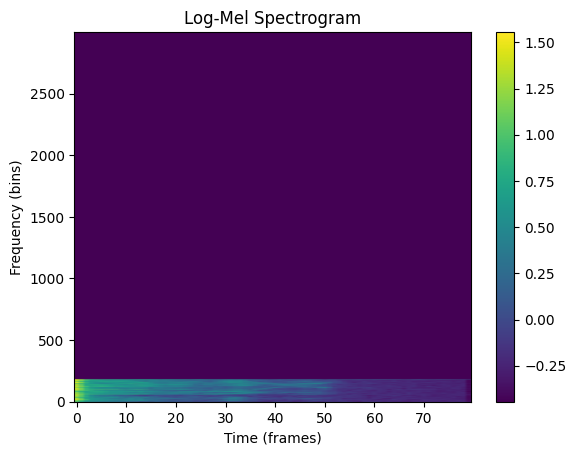

In [10]:
# Test for a single audio sample
audio_features = feature_extractor(final_dataset['train'][0]['audio']['array'], sampling_rate=final_dataset['train'][0]['audio']['sampling_rate'])
print(audio_features)
plt.imshow(audio_features['input_features'][0].T, aspect='auto', origin='lower')
plt.colorbar()
plt.title("Log-Mel Spectrogram")
plt.xlabel("Time (frames)")
plt.ylabel("Frequency (bins)")
plt.show()

In [11]:
final_dataset = final_dataset.map(prepare_dataset, remove_columns=final_dataset.column_names["train"])

Map:   0%|          | 0/11956 [00:00<?, ? examples/s]

Map:   0%|          | 0/1494 [00:00<?, ? examples/s]

Map:   0%|          | 0/1495 [00:00<?, ? examples/s]

In [12]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")
print(model)

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 512)
      (layers): ModuleList(
        (0-5): 6 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=False)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (fin

In [13]:
model.generation_config.language = "japanese"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None

In [14]:
# Data Collator

@dataclass
class DataCollatorNAMSeq2SeqPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt", return_attention_mask=True)

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [15]:
data_collator = DataCollatorNAMSeq2SeqPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

In [16]:
print(data_collator)
metric = evaluate.load("wer")

DataCollatorNAMSeq2SeqPadding(processor=WhisperProcessor:
- feature_extractor: WhisperFeatureExtractor {
  "chunk_length": 30,
  "dither": 0.0,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": true,
  "sampling_rate": 16000
}

- tokenizer: WhisperTokenizer(name_or_path='openai/whisper-base', vocab_size=50258, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|endoftext|>', '<|startoftranscript|>', '<|en|>', '<|zh|>', '<|de|>', '<|es|>', '<|ru|>', '<|ko|>', '<|fr|>', '<|ja|>', '<|pt|>', '<|tr|>', '<|pl|>', '<|ca|>', '<|nl|>', '<|ar|>', '<|sv|>', '<|it|>', '<|i

In [17]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    
    return {"wer": wer}


In [18]:
model.get_encoder()

WhisperEncoder(
  (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (embed_positions): Embedding(1500, 512)
  (layers): ModuleList(
    (0-5): 6 x WhisperEncoderLayer(
      (self_attn): WhisperAttention(
        (k_proj): Linear(in_features=512, out_features=512, bias=False)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (activation_fn): GELUActivation()
      (fc1): Linear(in_features=512, out_features=2048, bias=True)
      (fc2): Linear(in_features=2048, out_features=512, bias=True)
      (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_

In [19]:
# Freezing the base model layers to not update them during training
model = prepare_model_for_kbit_training(model)

In [20]:
def make_input_require_grad(module, input, output):
    output.requires_grad_(True)

model.model.encoder.conv1.register_forward_hook(make_input_require_grad)

In [21]:
config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
)

model = get_peft_model(model, config)
print(model.print_trainable_parameters())

trainable params: 294,912 || all params: 72,888,832 || trainable%: 0.4046
None


In [22]:
training_args = Seq2SeqTrainingArguments(
    output_dir="output",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=500,
    num_train_epochs=15,
    lr_scheduler_type="cosine",
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=128,
    max_grad_norm= 1.0,
    save_steps=500,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    remove_unused_columns=False,
    label_names=["labels"],
)

In [23]:
# This callback helps to save only the adapter weights and remove the base model weights.
class SavePeftModelCallback(TrainerCallback):
    def on_save(
        self,
        args: TrainingArguments,
        state: TrainerState,
        control: TrainerControl,
        **kwargs,
    ):
        checkpoint_folder = os.path.join(args.output_dir, f"{PREFIX_CHECKPOINT_DIR}-{state.global_step}")

        peft_model_path = os.path.join(checkpoint_folder, "adapter_model")
        kwargs["model"].save_pretrained(peft_model_path)

        pytorch_model_path = os.path.join(checkpoint_folder, "pytorch_model.bin")
        if os.path.exists(pytorch_model_path):
            os.remove(pytorch_model_path)
        return control


trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=processor.feature_extractor,
    callbacks=[SavePeftModelCallback],
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

In [24]:
trainer.train()

Step,Training Loss,Validation Loss,Wer
500,2.492100,2.870813,110.374833
1000,1.952900,2.376896,98.192771
1500,1.736000,2.204101,97.657296
2000,1.633000,2.117964,96.854083
2500,1.716100,2.056164,96.586345
3000,1.567700,2.010555,96.452477
3500,1.567600,1.980012,96.318608
4000,1.570300,1.954373,96.184739
4500,1.488700,1.929172,96.184739
5000,1.436900,1.914342,96.251673


TrainOutput(global_step=11220, training_loss=1.6160557483394302, metrics={'train_runtime': 19073.6687, 'train_samples_per_second': 9.402, 'train_steps_per_second': 0.588, 'total_flos': 1.17081526173696e+19, 'train_loss': 1.6160557483394302, 'epoch': 15.0})